# Group Project Proposal


## Introduction:

As students, balancing our life outside of school can be challenging. With the many distractions around us, it can be hard to determine how much time we should spend in our leisure, versus time spent on school. 

The dataset we will be using for this analysis was collected by Paulo Cortez from the University of Minho, GuimarÃ£es, Portugal. This dataset details the performance of students aged 15-22 from two Portugeuse secondary schools. Each row represents an observation of a single student, with the grades they received from each period (G1, G2, G3) along with various details of their life, such as how much free time they have, whether they are in a romantic relationship etc.

In this project, we propose using a K nearest neighbors (KNN)-model to explore the relationship between time spent on several distractions and the grades received in school.


# Load Relevant Libraries

In [36]:
library(tidyverse)
library(tidymodels)
library(repr)
set.seed(1000)

# Data Collection

idea from: https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data
data from: https://archive.ics.uci.edu/ml/machine-learning-databases/00320/


In [37]:
#make a temporary file 
tempfile <- tempfile()

#download file into temp 
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", 
              tempfile) 

#extract relevant files 
student_mat <- read.table(unz(tempfile, "student-mat.csv"), 
                          header = TRUE, 
                          sep = ";")
student_por <- read.table(unz(tempfile, "student-por.csv"), 
                          header = TRUE, 
                          sep = ";")
unlink(tempfile)

#read files to see
head(student_mat, 5)
head(student_por, 5)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13


## Tidying the data/Splitting into training and testing sets
To tidy the data we will need to merge both datasets into one combined set, we do this in the following cell. 
We also filter to just have the columns that we are interested in for our analysis.

Finally we split our dataset into a training and testing set.

For the remaining code in this notebooks, we will be working on the __training data__ only

In [24]:
total_set <- rbind(student_mat, student_por) 

filtered_set <- total_set %>% 
                select(goout, Dalc, Walc, G3)

data_split <- initial_split(filtered_set, prop = 0.75, strata = G3)  #where G3 = final grade
data_train <- training(data_split)   
data_test <- testing(data_split)
head(data_train, 4)

,goout,Dalc,Walc,G3
,<int>,<int>,<int>,<int>
1,4,1,1,6
3,2,2,3,10
4,2,1,1,15
5,2,1,2,10


## Summarizing data in a table

In the following cell we find the mean of our predictor variables goout, Dalc, Walc

In [25]:
predictor_means <- data_train %>%
                   select(goout, Dalc, Walc) %>%
                   map_df(mean)
predictor_means

goout,Dalc,Walc
<dbl>,<dbl>,<dbl>
3.142675,1.490446,2.271338


We can see that on average more people go out with their friends versus drinking alcohol on the weekdays or weekends. It will be interesting to see if this variable has a greater effect on students' grades versus alcohol consumption.

## Summarize the number of observations for each class

It is important to first see if the number of observations for each class is similar, otherwise the model will not be properly trained. 

In [38]:
instances_for_classes <- data_train %>%  
    select(G3) %>%  
    group_by(G3) %>%  
    summarize(n = n(),
            percentage = n() / nrow(data_train) * 100)

instances_for_classes

`summarise()` ungrouping output (override with `.groups` argument)



G3,n,percentage
<int>,<int>,<dbl>
0,40,5.0955414
1,1,0.1273885
5,6,0.7643312
6,13,1.6560510
7,15,1.9108280
8,53,6.7515924
9,51,6.4968153
10,109,13.8853503
11,114,14.5222930


## Modify initial dataset: Add Classification for G3 
 
To balance out the number of observations

In [32]:
data_train_new_classifier <- data_train %>% 
    mutate(G3_class = case_when((G3 >= 0 & G3 <= 5) ~ "very poor", 
                                (G3 >= 6 & G3 <= 10) ~ "poor",
                                (G3 >= 11 & G3 <= 15) ~ "average", 
                                (G3 >= 16 & G3 <= 20) ~ "good"))

head(data_train_new_classifier, 10)
unique(data_train_new_classifier$G3_class)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<chr>
1,4,1,1,6,poor
2,2,2,3,10,poor
3,2,1,1,15,average
4,2,1,2,10,poor
5,2,1,2,15,average
6,4,1,1,6,poor
7,2,1,1,19,good
8,1,1,1,15,average
9,3,1,2,9,poor


[1] "poor"      "average"   "good"      "very poor"

In [33]:
#Add summary 

summary <- data_train_new_classifier %>% 
    select(G3_class) %>% 
    group_by(G3_class) %>% 
    summarize(n = n(),
              percentage = n() / nrow(data_train) * 100)

summary
    

`summarise()` ungrouping output (override with `.groups` argument)



G3_class,n,percentage
<chr>,<int>,<dbl>
average,403,51.337580
good,94,11.974522
poor,241,30.700637
very poor,47,5.987261


## Visualization: 
In the following cells we provide plots that display the count of how many people got good grades (G3 >= 15) for each predictor variable

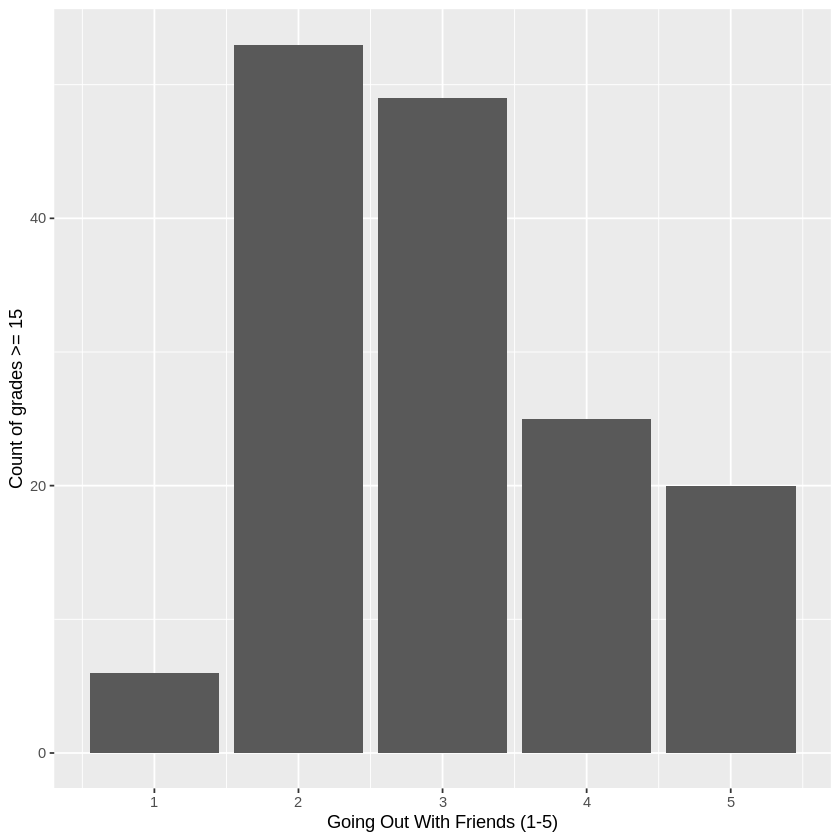

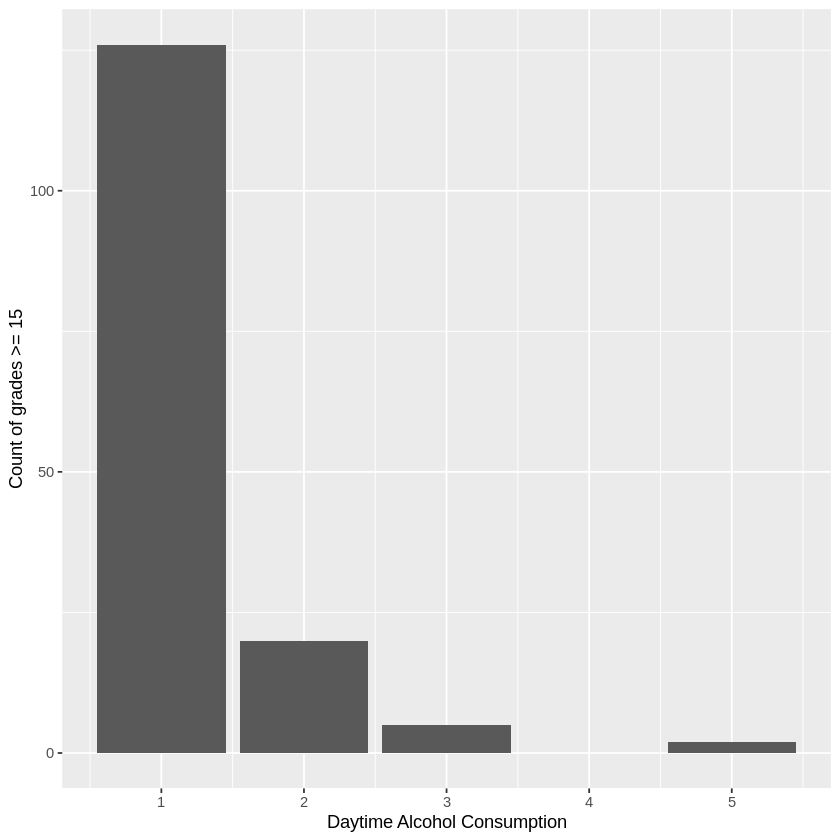

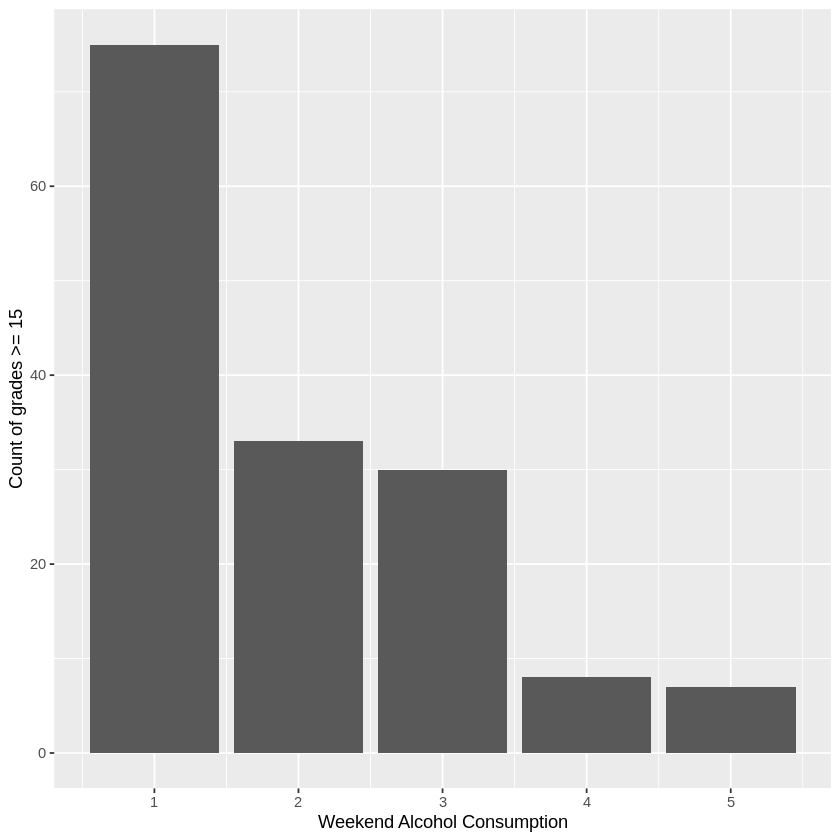

In [7]:
goout_viz <- data_train %>%
             filter(G3 >= 15) %>%
             ggplot(aes(x = goout)) +
             geom_bar() +
             xlab("Going Out With Friends (1-5)") +
             ylab("Count of grades >= 15")
dalc_viz <- data_train %>%
            filter(G3 >= 15) %>%
             ggplot(aes(x = Dalc)) +
             geom_bar() +
             xlab("Daytime Alcohol Consumption") +
             ylab("Count of grades >= 15")
walc_viz <- data_train %>%
            filter(G3 >= 15) %>%
             ggplot(aes(x = Walc)) +
             geom_bar() +
             xlab("Weekend Alcohol Consumption") +
             ylab("Count of grades >= 15")
goout_viz
dalc_viz
walc_viz

We can see that there is a clear trend with alcohol consumption - students who drink more alcohol tend to not get good grades. However, the trend is not as clear with the "going out with friends" variable. 

# Methods

We are interested in finding the relationship between going out with friends, alcohol consumption, and school performance.

We will be using the columns
- "goout": time spent going out with friends,
- "Dalc": workday alcohol consumption, and
- "Walc": weekend alcohol consumption 
as our predictors in order to make a model that predicts students' (G3_class) final grade based on their level of engagement on these activities. 

The other columns in the dataset are not relevant since they are not considered distractions so we exclude them. With these variables we will create a k-nn model in order to predict the grade a student will receive given values for "goout", "Dalc", and "Walc".

One way we wish to visualize our data would be to create a scatterplot with our model and divide the graph into areas that would predict good, average, poor, or very poor grades. One could then approximate a student's grade visually. 

# Expected Outcomes and Significance

What do you expect to find?
- We expect a negative correlation between grades and alcohol consumption (both workday and weekend) 
- We expect the relationship between going out with friends 

What impact could such findings have?
- These results can highlight the effects of alcohol consumption on school grades for students aged 15-22
- These results can show the positive and negative effects of going out with friends, and perhaps elucidate a “sweet spot” for this activity

What future questions could this lead to?
- What is the best strategy to balance distractions outside school while still achieving good performance? 
- Can we use this model to assist in early intervention for students who have poor predicted grades?
